In [61]:
# Imports & Parameters
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Parameters
START_DATE = '2020-01-01'
END_DATE = '2026-06-01'

# Top10 ['BTC-USD', 'ETH-USD', 'XRP-USD', 'BNB-USD', 'SOL-USD', 'TRX-USD', 'ADA-USD', 'DOGE-USD', 'ZEC-USD', 'LINK-USD']
# Top20 Generated ['BTC-USD', 'ETH-USD', 'XRP-USD', 'BNB-USD', 'ADA-USD', 'DOGE-USD', 'TRX-USD', 'MATIC-USD', 'LTC-USD', 'LINK-USD', 'BCH-USD', 'XLM-USD', 'ETC-USD', 'ATOM-USD', 'XMR-USD', 'VET-USD', 'ALGO-USD', 'FIL-USD', 'UNI-USD', 'EOS-USD']
# Top20 CMC as of January 2026 ['BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'ADA-USD', 'DOGE-USD', 'SOL-USD', 'TRX-USD', 'DOT-USD', 'MATIC-USD', 'LTC-USD', 'LINK-USD', 'BCH-USD', 'XLM-USD', 'ETC-USD', 'ATOM-USD', 'XMR-USD', 'VET-USD', 'ALGO-USD', 'FIL-USD']
# Top4 old ['BTC-USD', 'ETH-USD', 'XRP-USD', 'ADA-USD']

TICKERS = ['BTC-USD', 'ETH-USD', 'XRP-USD', 'BNB-USD', 'SOL-USD', 'TRX-USD', 'ADA-USD', 'DOGE-USD', 'ZEC-USD', 'LINK-USD']

WINDOW_PSMA = 30
WINDOW_RANGE = 25
WINDOW_RRP = 20

In [62]:
# Download data for all tickers and add features
data = yf.download(TICKERS, start=START_DATE, end=END_DATE, auto_adjust=True, progress=False)

# Returns
returns = data['Close'].pct_change(fill_method=None)
returns.columns = pd.MultiIndex.from_product([['Returns'], returns.columns])

# Log Returns
log_returns = np.log(data['Close'] / data['Close'].shift(1))
log_returns.columns = pd.MultiIndex.from_product([['LogReturns'], log_returns.columns])

# Next day returns (shifted returns)
next_day_returns = returns.shift(-1)
next_day_returns.columns = pd.MultiIndex.from_product([['NextDayReturns'], TICKERS])

### MOMENTUM
# 20-day momentum (cumulative return over past 20 days)
momentum_20d = data['Close'].pct_change(periods=20, fill_method=None)
momentum_20d.columns = pd.MultiIndex.from_product([['Momentum20D'], momentum_20d.columns])

# Volatility-normalized momentum
volatility_20d = momentum_20d['Momentum20D'].rolling(window=20).std()
volatility_20d.columns = pd.MultiIndex.from_product([['Volatility20D'], volatility_20d.columns])

# Normalized momentum = momentum / volatility
# Extract the ticker-level data for both to align them properly
momentum_values = momentum_20d['Momentum20D']
volatility_values = volatility_20d['Volatility20D']

normalized_momentum_20d = momentum_values / volatility_values
normalized_momentum_20d.columns = pd.MultiIndex.from_product([['NormalizedMomentum20D'], TICKERS])
normalized_momentum_20d = normalized_momentum_20d.dropna()

# Bounded signal using fixed limits -2, 2 and scaled by 0.75
lower_limit = -2
upper_limit = 2
scale_factor = 0.75

momentum_signal_fixed = normalized_momentum_20d.clip(lower=lower_limit, upper=upper_limit) * scale_factor
momentum_signal_fixed.columns = pd.MultiIndex.from_product([['MomentumSignalFixed'], TICKERS])


#### DAYS SINCE LAST HIGH
# Days since highest close in past 20 days
days_since_high_20d = pd.DataFrame(index=data.index)

for ticker in TICKERS:
    # Get close prices
    close_prices = data['Close'][ticker]
    
    # For each day, compute days since highest close in past 20 days (including current day)
    days_since_high = []
    
    for i in range(len(close_prices)):
        # Need at least 20 observations
        if i < 19:
            days_since_high.append(np.nan)
        else:
            # Get the past 20 days (including current day)
            window = close_prices.iloc[i-19:i+1]
            # Check if window has any non-NA values
            if window.isna().all():
                days_since_high.append(np.nan)
            else:
                # Find the index of the maximum value
                max_idx = window.idxmax()
                # Calculate days since that maximum
                days_since_high.append((close_prices.index[i] - max_idx).days)
    
    days_since_high_20d[ticker] = days_since_high

# Convert to MultiIndex columns to match other features
days_since_high_20d.columns = pd.MultiIndex.from_product([['DaysSinceHigh20D'], TICKERS])

# Normalize days_since_high_20d using exponential shaping
# u_i,t = (1 - DSH_i,t / (L-1))^gamma
# where L = 20 (window length), so L-1 = 19

L = 20
gamma = 1.5  # Controls aggressiveness (>1 = more selective, <1 = more forgiving)

# Calculate normalized days since high
normalized_days_since_high = pd.DataFrame(index=days_since_high_20d.index)

for ticker in TICKERS:
    # Get days since high values
    dsh_values = days_since_high_20d[('DaysSinceHigh20D', ticker)]
    
    # Apply normalization formula: (1 - DSH / (L-1))^gamma
    normalized_values = (1 - dsh_values / (L - 1)) ** gamma
    
    # Clip negative values to 0 (in case DSH > L-1)
    normalized_values = normalized_values.clip(lower=0)
    
    normalized_days_since_high[ticker] = normalized_values

# Convert to MultiIndex columns
normalized_days_since_high.columns = pd.MultiIndex.from_product([['NormalizedDaysSinceHigh'], TICKERS])


#### PSMA
# Simple Moving Average
sma = data['Close'].rolling(window=WINDOW_PSMA).mean()
sma.columns = pd.MultiIndex.from_product([['SMA'], sma.columns])

sma_volatility = sma['SMA'].rolling(window=WINDOW_PSMA).std()
sma_volatility.columns = pd.MultiIndex.from_product([['SMAVolatility'], sma_volatility.columns])

# Volatility-normalized PSMA
psma = data['Close'] / sma['SMA']
normalized_psma = (psma - 1) / sma_volatility['SMAVolatility']
normalized_psma.columns = pd.MultiIndex.from_product([['NormalizedPSMA'], normalized_psma.columns])

# Bound normalized_psma using tanh
normalized_psma_bounded = np.tanh(normalized_psma)
normalized_psma_bounded.columns = pd.MultiIndex.from_product([['NormalizedPSMABounded'], TICKERS])


##### RANGE
# Raw Range (R_i,t) = (max - min) / current_price over lookback window
lookback = WINDOW_RANGE
rolling_max = data['Close'].rolling(window=lookback).max()
rolling_min = data['Close'].rolling(window=lookback).min()
raw_range = (rolling_max - rolling_min) / data['Close']
raw_range.columns = pd.MultiIndex.from_product([['RawRange'], raw_range.columns])

# Bounded signal using fixed limit
range_signal_fixed = raw_range.clip(upper=1)
range_signal_fixed.columns = pd.MultiIndex.from_product([['RangeSignalFixed'], TICKERS])



##### RRP
# Rolling mean return (μ_i,t)
rolling_mean = log_returns.rolling(window=WINDOW_RRP).mean()
# Don't set MultiIndex yet - keep it flat for division

# Rolling standard deviation (σ_i,t)
rolling_std = log_returns.rolling(window=WINDOW_RRP).std()
# Don't set MultiIndex yet - keep it flat for division

# Raw RRP (μ_i,t / σ_i,t)
# Extract the values from the MultiIndex structure first
rolling_mean_values = rolling_mean.droplevel(0, axis=1)
rolling_std_values = rolling_std.droplevel(0, axis=1)
raw_rrp = rolling_mean_values / rolling_std_values
raw_rrp.columns = pd.MultiIndex.from_product([['RawRRP'], TICKERS])

# Normalize RRP across time (z-score normalization)
# Calculate rolling mean and std of RRP across all tickers for each date
rrp_cross_sectional_mean = raw_rrp.mean(axis=1)
rrp_cross_sectional_std = raw_rrp.std(axis=1)

# Create normalized RRP (z-score)
normalized_rrp = raw_rrp.copy()
for ticker in TICKERS:
    normalized_rrp[('RawRRP', ticker)] = (
        (raw_rrp[('RawRRP', ticker)] - rrp_cross_sectional_mean) / rrp_cross_sectional_std
    )

In [63]:
# Backtest: Bounded Signal Strategy with fixed limits

# Initialize a DataFrame to store all returns
all_returns = pd.DataFrame()

# Iterate through each ticker
for idx, ticker in enumerate(TICKERS):

    # Prepare data for this ticker
    df_returns_fixed = pd.DataFrame({
        'next_day_returns': next_day_returns[('NextDayReturns', ticker)],
        'momentum_signal_fixed': momentum_signal_fixed[('MomentumSignalFixed', ticker)],
        'normalized_days_since_high': normalized_days_since_high[('NormalizedDaysSinceHigh', ticker)],
        'normalized_psma_bounded': normalized_psma_bounded[('NormalizedPSMABounded', ticker)],
        'range_signal_fixed': range_signal_fixed[('RangeSignalFixed', ticker)],
        'normalized_rrp': normalized_rrp[('RawRRP', ticker)]
    }).dropna().copy()
    
    # Strategy: Bounded signal - long only (only take position when signal > 0)
    df_returns_fixed['returns_bounded_l'] = df_returns_fixed['next_day_returns'] * (
        (1/5) * df_returns_fixed['momentum_signal_fixed'].clip(lower=0) +
        (1/5) * df_returns_fixed['normalized_days_since_high'].clip(lower=0) +
        (1/5) * df_returns_fixed['normalized_psma_bounded'].clip(lower=0) +
        (1/5) * df_returns_fixed['range_signal_fixed'].clip(lower=0) +
        (1/5) * df_returns_fixed['normalized_rrp'].clip(lower=0)
    )
    
    # Add to all_returns_bounded DataFrame
    all_returns[ticker] = df_returns_fixed['returns_bounded_l']

In [64]:
# Calculate portfolio returns as the mean across all tickers for each day
portfolio_returns = all_returns.mean(axis=1)

# Calculate cumulative returns
cumulative_portfolio_returns = (1 + portfolio_returns).cumprod()

# Calculate performance metrics
total_return = (cumulative_portfolio_returns.iloc[-1] - 1) * 100
num_days = len(portfolio_returns)
num_years = num_days / 365  # Crypto markets open 365 days
annualized_return = (cumulative_portfolio_returns.iloc[-1] ** (365 / num_days) - 1) * 100
annualized_volatility = portfolio_returns.std() * np.sqrt(365) * 100
sharpe_ratio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(365)

# Calculate maximum drawdown
cumulative = (1 + portfolio_returns).cumprod()
running_max = cumulative.expanding().max()
drawdown = (cumulative - running_max) / running_max
max_drawdown = drawdown.min() * 100

# Display results
print("=" * 60)
print("BACKTEST RESULTS")
print("=" * 60)
print("Strategy: Combination of trend following indicators")
print(f"Period: {portfolio_returns.index[0].strftime('%Y-%m')} to {portfolio_returns.index[-1].strftime('%Y-%m')}")
print(f"Number of years: {num_years:.2f}")
print("-" * 60)
print(f"Total Return: {total_return:.2f}%")
print(f"Annualized Return: {annualized_return:.2f}%")
print(f"Annualized Volatility: {annualized_volatility:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.3f}")
print(f"Maximum Drawdown: {max_drawdown:.2f}%")
print("=" * 60)

BACKTEST RESULTS
Strategy: Combination of trend following indicators
Period: 2020-05 to 2026-01
Number of years: 5.64
------------------------------------------------------------
Total Return: 2382.70%
Annualized Return: 76.82%
Annualized Volatility: 31.62%
Sharpe Ratio: 1.961
Maximum Drawdown: -33.42%


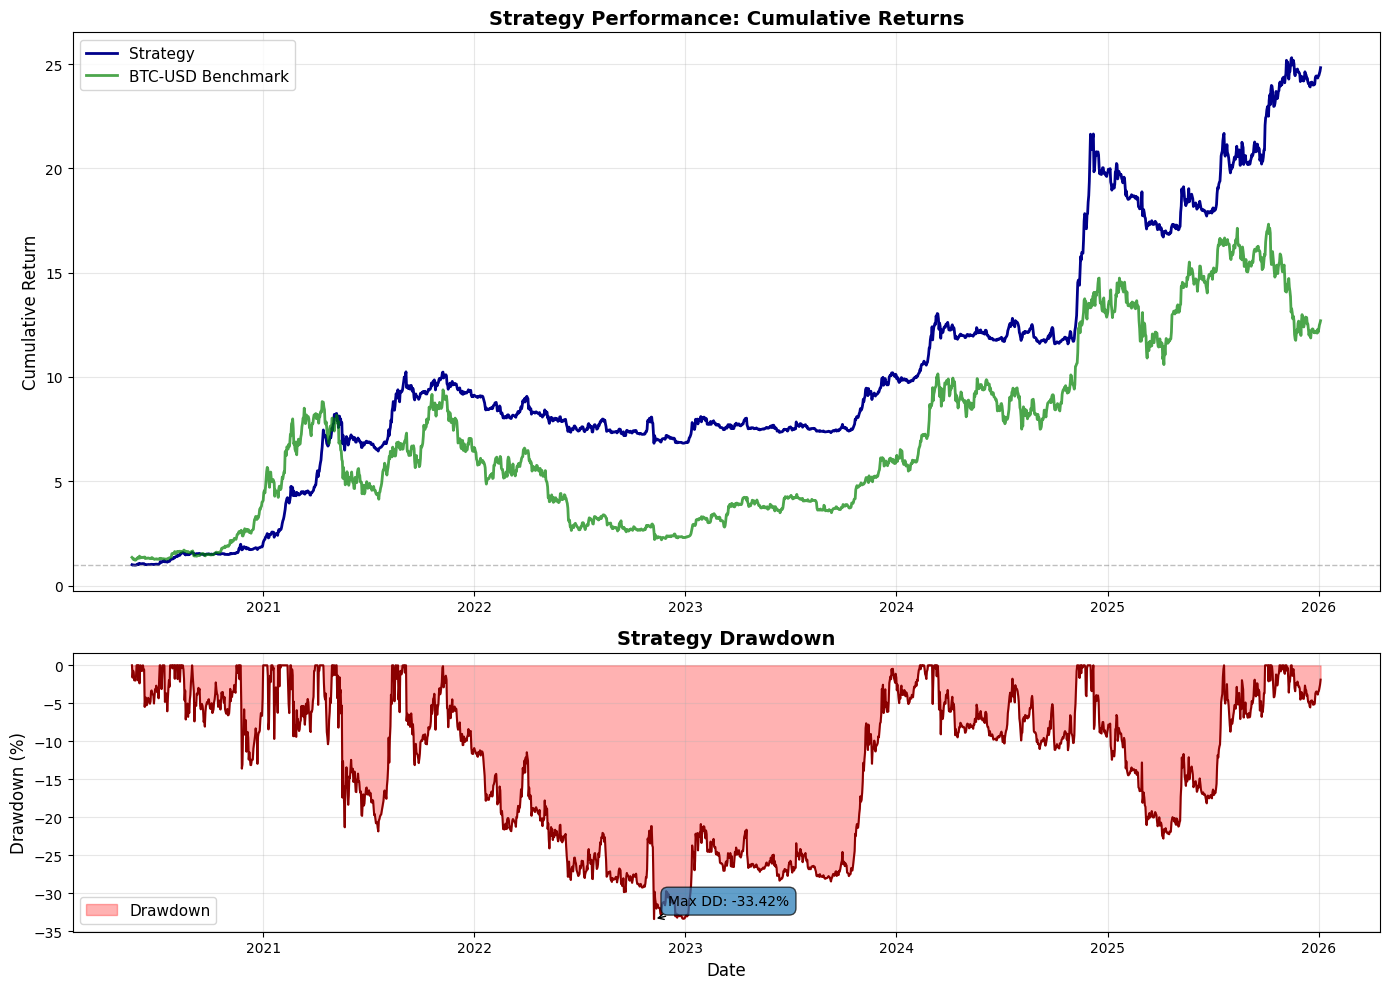

In [65]:
# Download BTC-USD benchmark data
btc_returns = returns[('Returns', 'BTC-USD')]
cumulative_btc = (1 + btc_returns).cumprod()

# Align BTC benchmark with portfolio returns for fair comparison
cumulative_btc_aligned = cumulative_btc.reindex(cumulative_portfolio_returns.index)

# Create strategy performance and drawdown plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [2, 1]})

# Plot 1: Cumulative Returns (Equity Curve)
ax1.plot(cumulative_portfolio_returns.index, cumulative_portfolio_returns, 
         linewidth=2, label='Strategy', color='darkblue')
ax1.plot(cumulative_btc_aligned.index, cumulative_btc_aligned, 
         linewidth=2, label='BTC-USD Benchmark', color='green', alpha=0.7)

ax1.set_ylabel('Cumulative Return', fontsize=12)
ax1.set_title('Strategy Performance: Cumulative Returns', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11, loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=1, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Plot 2: Drawdown
ax2.fill_between(drawdown.index, drawdown * 100, 0, 
                 color='red', alpha=0.3, label='Drawdown')
ax2.plot(drawdown.index, drawdown * 100, 
         linewidth=1.5, color='darkred')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Drawdown (%)', fontsize=12)
ax2.set_title('Strategy Drawdown', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11, loc='lower left')
ax2.grid(True, alpha=0.3)

# Add annotation for max drawdown
max_dd_date = drawdown.idxmin()
ax2.annotate(f'Max DD: {max_drawdown:.2f}%', 
             xy=(max_dd_date, drawdown.min()*100),
             xytext=(10, 10), textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.5', alpha=0.7),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.show()

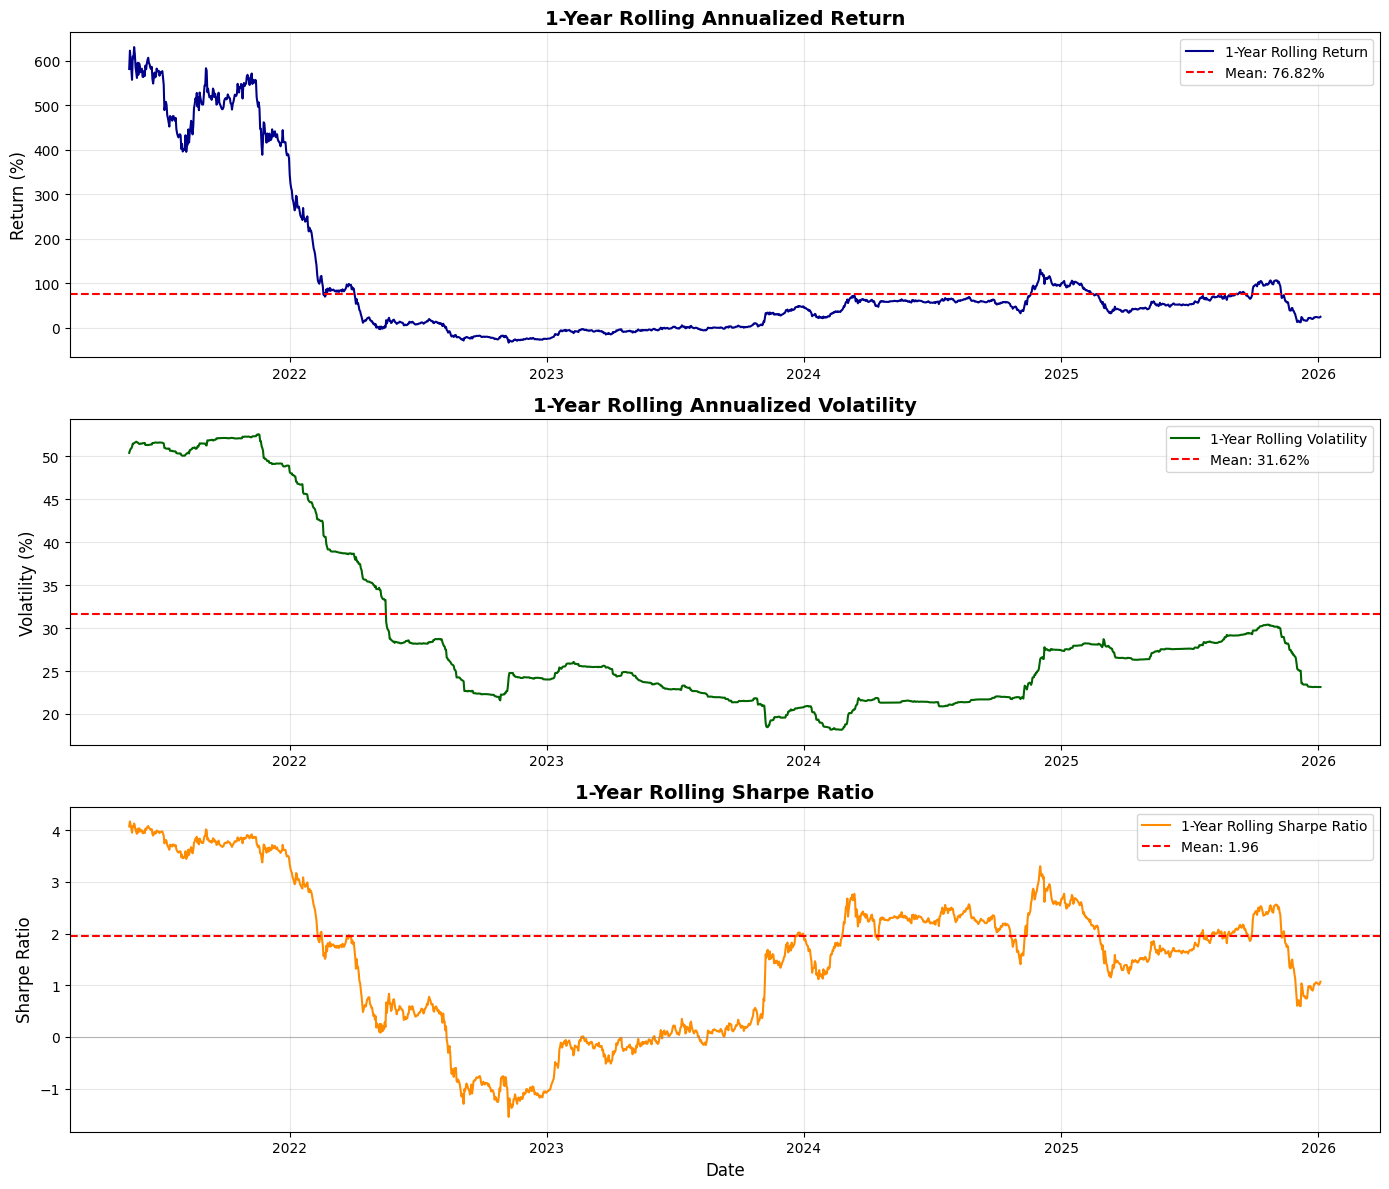

In [66]:
# Calculate 1-year rolling metrics for the strategy
rolling_window = 365  # 365 days = 1 year (crypto markets trade daily)

# 1-year rolling return (annualized)
rolling_return = portfolio_returns.rolling(window=rolling_window).apply(
    lambda x: (1 + x).prod() - 1
)

# 1-year rolling volatility (annualized)
rolling_vol = portfolio_returns.rolling(window=rolling_window).std() * np.sqrt(365)

# 1-year rolling Sharpe ratio
rolling_sharpe = (portfolio_returns.rolling(window=rolling_window).mean() / 
                  portfolio_returns.rolling(window=rolling_window).std()) * np.sqrt(365)

# Create the plots
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Plot 1: Rolling Return
ax1 = axes[0]
ax1.plot(rolling_return.index, rolling_return * 100, 
         linewidth=1.5, color='darkblue', label='1-Year Rolling Return')
ax1.axhline(y=annualized_return, color='red', linestyle='--', linewidth=1.5, 
            label=f'Mean: {annualized_return:.2f}%')
ax1.set_ylabel('Return (%)', fontsize=12)
ax1.set_title('1-Year Rolling Annualized Return', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Rolling Volatility
ax2 = axes[1]
ax2.plot(rolling_vol.index, rolling_vol * 100, 
         linewidth=1.5, color='darkgreen', label='1-Year Rolling Volatility')
ax2.axhline(y=annualized_volatility, color='red', linestyle='--', linewidth=1.5, 
            label=f'Mean: {annualized_volatility:.2f}%')
ax2.set_ylabel('Volatility (%)', fontsize=12)
ax2.set_title('1-Year Rolling Annualized Volatility', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Plot 3: Rolling Sharpe Ratio
ax3 = axes[2]
ax3.plot(rolling_sharpe.index, rolling_sharpe, 
         linewidth=1.5, color='darkorange', label='1-Year Rolling Sharpe Ratio')
ax3.axhline(y=sharpe_ratio, color='red', linestyle='--', linewidth=1.5, 
            label=f'Mean: {sharpe_ratio:.2f}')
ax3.axhline(y=0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
ax3.set_xlabel('Date', fontsize=12)
ax3.set_ylabel('Sharpe Ratio', fontsize=12)
ax3.set_title('1-Year Rolling Sharpe Ratio', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()